In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess


import read_config_utils as cu


from os.path import exists


import pickle


In [2]:
nbins = 100

xlow = -4.5
xhigh = 4.5

binwidth = (xhigh-xlow)/nbins

xvals = np.linspace( xlow+binwidth/2., xhigh-binwidth/2, nbins)

fileset = 1

ndirs = 0

input_dirs = []

if fileset == 1 :
    
    input_dirs.append('output-run-kde-study-1d-v1a-res-sf-1.00/')
    input_dirs.append('output-run-nn-study-nd-v1f-ndim1-res-sf-1.00-nens10-relu/')
    input_dirs.append('output-run-nn-study-nd-v1c-ndim1-res-sf-1.00/')
    input_dirs.append('output-run-nn-study-nd-v1f-ndim1-res-sf-1.00-nens10-beta1/')
    

    ndirs = 4
    dir_labels = [
        'KDE',
        'relu',
        'gelu, $\\beta=4$',
        'gelu, $\\beta=1$'
    ]

    
nsamples = 3
sample_indices = [0,1,2]

In [3]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * mc_pts[:,fi1] )
    wx2 = np.sum( weights * mc_pts[:,fi2] )
    wx1x2 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * mc_pts[:,fi1] * mc_pts[:,fi1] )
        wx2x2 = np.sum( weights * mc_pts[:,fi2] * mc_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict



In [4]:
def hist_to_func( hist_bin_data, xe, ye ) :
    
    return_array = np.zeros( hist_bin_data.shape[0] )
    
    xvals = np.zeros( hist_bin_data.shape[0] )
    yvals = np.zeros( hist_bin_data.shape[0] )
    
    for bi in range( hist_bin_data.shape[0] ) :
        xvals[bi] = 0.5 * (xe[bi] + xe[bi+1] )
        yvals[bi] = 0.5 * (ye[bi] + ye[bi+1] )

    
    for bi0 in range(hist_bin_data.shape[0]) :
        esum = 0
        biesum = 0    
        for bi1 in range(hist_bin_data.shape[1]) :
            esum += hist_bin_data[bi0,bi1]
            #biesum += bi1*hist_bin_data[bi0,bi1]
            biesum += yvals[bi1]*hist_bin_data[bi0,bi1]

        wave = 0
        if esum > 0 :
            wave = biesum / esum
        return_array[bi0] = wave
        
    return return_array, xvals



  Dir  0, sample   0 :  mean    0.193,    cov    0.800
  Dir  1, sample   0 :  mean    0.195,    cov    0.804
  Dir  2, sample   0 :  mean    0.195,    cov    0.802
  Dir  3, sample   0 :  mean    0.195,    cov    0.803

  Dir  0, sample   1 :  mean    0.202,    cov    0.818
  Dir  1, sample   1 :  mean    0.198,    cov    0.823
  Dir  2, sample   1 :  mean    0.198,    cov    0.820
  Dir  3, sample   1 :  mean    0.198,    cov    0.820

  Dir  0, sample   2 :  mean    0.208,    cov    0.816
  Dir  1, sample   2 :  mean    0.208,    cov    0.818
  Dir  2, sample   2 :  mean    0.208,    cov    0.813
  Dir  3, sample   2 :  mean    0.208,    cov    0.812


<function matplotlib.pyplot.show(close=None, block=None)>

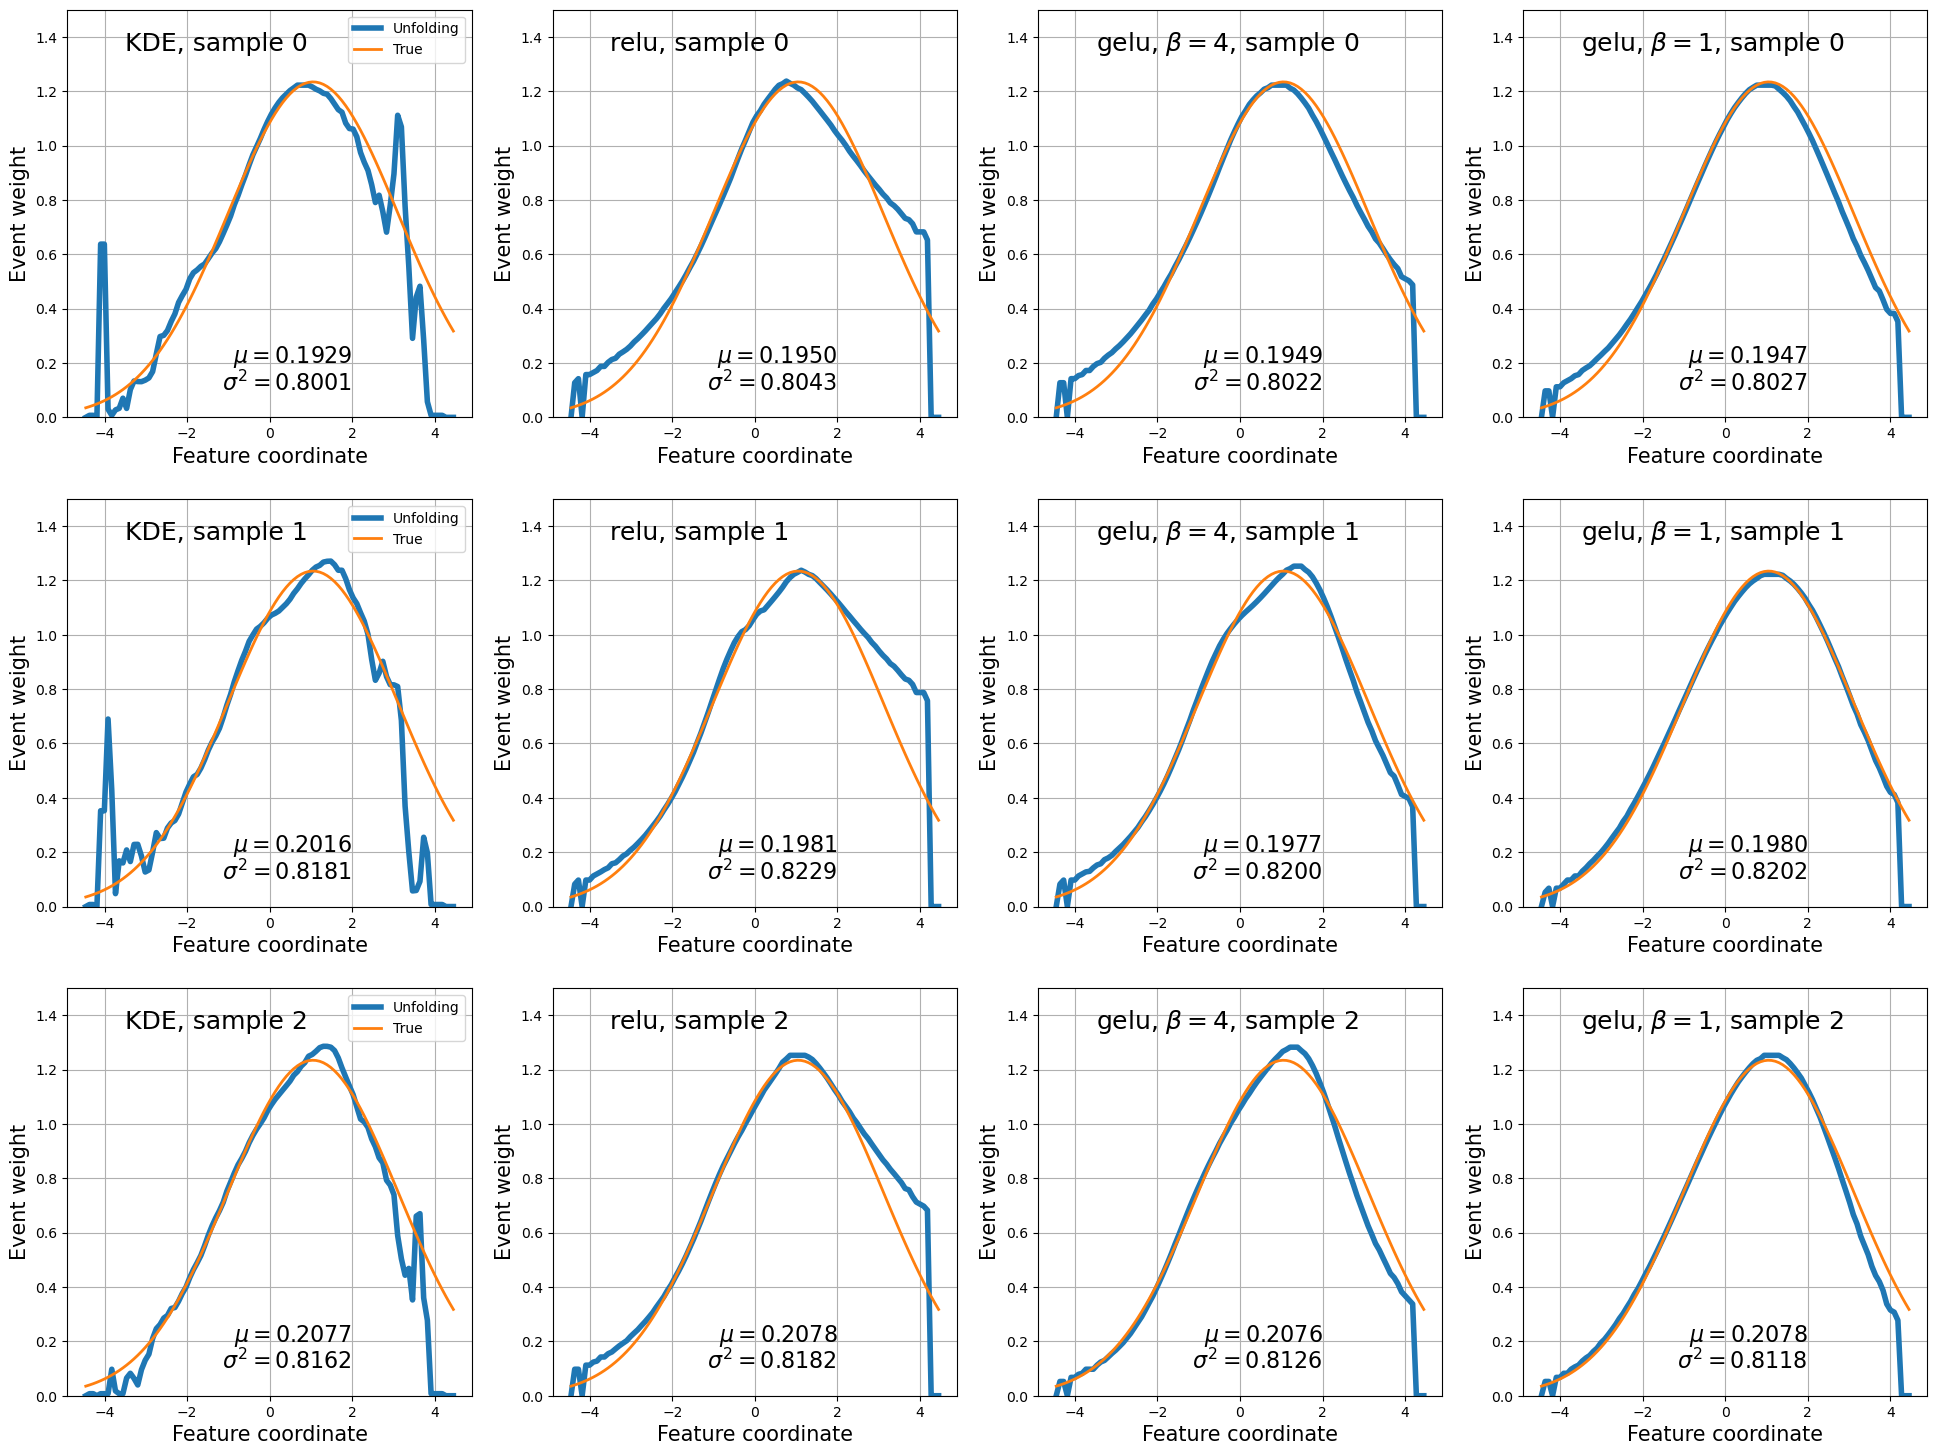

In [19]:

verbose = False

nsamples=3
sample_indices = [0,1,3]




#nsamples=20
#sample_indices=[]
#for i in range(nsamples) :
#    sample_indices.append(40+i)

fig,ax = plt.subplots( nsamples, ndirs, figsize=(ndirs*6,nsamples*6) )


for si in range( nsamples ) :
    
    print()

    for di in range( ndirs ) :
    
    
        
        if verbose : print('\n\n ======= begin dir %d, sample %d \n' % (di,si))

        
        config_file = '%s/config.txt' % (input_dirs[di])

        if not exists(config_file) :

            if verbose : print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
            sys.exit()

        ndim = int(cu.get_par( config_file, "ndim"))
        if verbose : print("\n\n Number of feature dimensions: %d\n\n" % ndim)

        if ndim != 1 :

            print('\n\n *** cant do this for ndim>1\n\n')
            sys.exit()
            
        with open( '%s/config-pars.pkl' % input_dirs[di], 'rb') as f :
            mc_mu = pickle.load(f)
            mc_rho = pickle.load(f)
            mc_sig = pickle.load(f)
            true_mu = pickle.load(f)
            true_rho = pickle.load(f)
            true_sig = pickle.load(f)
            resolution = pickle.load(f)
            mc_cov = pickle.load(f)
            true_cov = pickle.load(f)

        if verbose : print('true_mu %.3f,  MC_mu %.3f' % (true_mu[0], mc_mu[0]))

        if verbose : print('true_cov[0,0] %.3f,  mc_cov[0,0]  %.3f' % (true_cov[0,0], mc_cov[0,0]))
        
        with open( '%s/mc-and-true-samples.npy' % input_dirs[di], 'rb') as f :
            mc_pts = np.load(f)
            mc_det_pts = np.load(f)
            true_pts = np.load(f)
            true_det_pts = np.load(f)

        if verbose : 
            print()
            print('mc_pts     shape :  %s ' % str(mc_pts.shape))
            print('mc_det_pts shape :  %s' % str(mc_det_pts.shape))
            print('true_pts      shape :  %s' % str(true_pts.shape))
            print('true_det_pts  shape :  %s' % str(true_det_pts.shape))
            print()

        
        fname = '%s/bootstrap-points-%03d.npy' % (input_dirs[di], sample_indices[si])

        if exists(fname) :

            if verbose : print('\n----- %s exists' % fname )

            with open(fname,'rb') as f :

                sample_points = np.load(f)

                if verbose : print('sample_points shape: %s' % str(sample_points.shape))


        fname = '%s/bootstrap-weights-%03d.npy' % (input_dirs[di], sample_indices[si])

        if exists(fname) :

            if verbose : print('\n----- %s exists' % fname )

            with open(fname,'rb') as f :

                final_push_weights_scaled = np.load(f)

                if verbose : print('final_push_weights_scaled shape: %s' % str(final_push_weights_scaled.shape))

        undo_sf = (1.*final_push_weights_scaled.shape[0])/(1.*sample_points.shape[0])
        if verbose : print('\n Undo sf:  %.4f' % undo_sf)

        final_push_weights = undo_sf * final_push_weights_scaled
      

        if verbose :
            print()
            print('true_pts : \n%s' % true_pts[:,0] )
            print()
            print('mc_pts   : \n%s' % mc_pts[:,0])
            print()
            print('weights : \n%s' % final_push_weights )
            print()    
        
        hpw,xe,ye = np.histogram2d( mc_pts[:,0], final_push_weights, 
                      bins=[nbins,nbins], range=([xlow,xhigh],[0.,1.5]) )
        
        ave_fpw, xvals2 = hist_to_func( hpw, xe, ye )

        
        
        gaus_true = (1./np.sqrt(2*3.14159265*true_cov[0,0]))*np.exp(-1*np.power(xvals-true_mu[0],2)/(2*true_cov[0,0]))
        gaus_mc   = (1./np.sqrt(2*3.14159265*mc_cov[0,0]))*np.exp(-1*np.power(xvals-mc_mu[0],2)/(2*  mc_cov[0,0]))
        true_weight = gaus_true/gaus_mc
        
        
        mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )
        
        sample_inference_mean = mean_cov["mean_x1"]
        sample_inference_cov  = mean_cov["cov_x1x2"]
        
        print('  Dir %2d, sample %3d :  mean %8.3f,    cov %8.3f' % 
              (di, si, sample_inference_mean, sample_inference_cov))
        
        axi = ax[si,di]
        

        axi.plot(xvals,ave_fpw, linewidth=4, label='Unfolding' )
        axi.plot(xvals,true_weight, linewidth=2, label='True' )
        
        axi.set_ylim( [0,1.5] )
        
        fs = 15
        axi.set_xlabel('Feature coordinate', fontsize=fs)
        axi.set_ylabel('Event weight', fontsize=fs)
        
        if di == 0 :
            axi.legend(loc='upper right')
        
        
        tx = 2
        ty = 0.2
        tfs = 16
        axi.text( tx, ty, '$\mu = %7.4f$' % sample_inference_mean, 
                 fontsize=tfs, horizontalalignment='right' )
        ty = 0.1
        axi.text( tx, ty, '$\sigma^2 = %7.4f$' % sample_inference_cov, 
                 fontsize=tfs, horizontalalignment='right' )
        
        ty = 1.35
        tx = -3.5
        tfs = 18
        axi.text( tx, ty, '%s, sample %d' % (dir_labels[di], si),
                 fontsize=tfs
                )
        
        
        
        axi.grid(True)

        
        
        
plt.savefig( 'paper-plots/weight-functions.pdf' , bbox_inches='tight' )

        
    
plt.show